### Konfiguracja nowego klienta Hazelcast

In [53]:
import hazelcast

client = hazelcast.HazelcastClient(
            cluster_name = "dev",
            cluster_members=["127.0.0.1:5701", "127.0.0.1:5702", "127.0.0.1:5703"],
        )


Debug - sprawdzenie typu klucza: 

In [54]:
from hazelcast.aggregator import count, number_avg, max_by
from hazelcast.predicate import less_or_equal

imap = client.get_map("coinbase_trades").blocking()

entry_set = imap.entry_set()
first_key, _ = next(iter(entry_set))
print(f"Key type: {type(first_key)}") 
print(f"Value type: {type(_)}") 

Key type: <class 'str'>
Value type: <class 'hazelcast.core.HazelcastJsonValue'>


### Mapping SQL - prosty przykład

In [9]:
cities = client.get_map("cities").blocking()

client.sql.execute(
    """
CREATE MAPPING cities (
__key INT,
countries VARCHAR,
cities VARCHAR)
TYPE IMap
OPTIONS('keyFormat'='int', 'valueFormat'='json-flat')

    """
).result()

client.sql.execute(
    """
INSERT INTO cities VALUES
(1, 'United Kingdom','London'),
(2, 'United Kingdom','Manchester'),
(3, 'United States', 'New York'),
(4, 'United States', 'Los Angeles'),
(5, 'Turkey', 'Ankara'),
(6, 'Turkey', 'Istanbul'),
(7, 'Brazil', 'Sao Paulo'),
(8, 'Brazil', 'Rio de Janeiro')
    """
).result()

result = client.sql.execute("SELECT * FROM cities").result()


In [32]:
for row in result:
    print(row)

[__key INTEGER=2, countries VARCHAR=United Kingdom, cities VARCHAR=Manchester]
[__key INTEGER=7, countries VARCHAR=Brazil, cities VARCHAR=Sao Paulo]
[__key INTEGER=1, countries VARCHAR=United Kingdom, cities VARCHAR=London]
[__key INTEGER=3, countries VARCHAR=United States, cities VARCHAR=New York]
[__key INTEGER=6, countries VARCHAR=Turkey, cities VARCHAR=Istanbul]
[__key INTEGER=5, countries VARCHAR=Turkey, cities VARCHAR=Ankara]
[__key INTEGER=8, countries VARCHAR=Brazil, cities VARCHAR=Rio de Janeiro]
[__key INTEGER=4, countries VARCHAR=United States, cities VARCHAR=Los Angeles]


In [36]:
# Zamknięcie klienta Hazelcast
client.shutdown()

## SQL do Ticker

In [58]:
#trades = client.get_map("coinbase_trades").blocking()

client.sql.execute(
    """

CREATE OR REPLACE MAPPING coinbase_trades
TYPE IMap
OPTIONS (
    'keyFormat' = 'varchar',
    'valueFormat' = 'json'   
);
    """
).result()


In [97]:
result_trades = client.sql.execute(
    """
    
    SELECT * 
    FROM coinbase_trades 
    where cast(JSON_VALUE(this, '$.price' RETURNING varchar) as decimal) > 99416
    """).result()

for row in result_trades:
    print(row)

[__key VARCHAR=96871408726, this JSON={"type": "ticker", "sequence": 96871408726, "product_id": "BTC-USD", "price": "99416.21", "open_24h": "96727.09", "volume_24h": "12274.37838309", "low_24h": "96069.36", "high_24h": "99800", "volume_30d": "318441.86104508", "best_bid": "99416.20", "best_bid_size": "0.03000000", "best_ask": "99416.21", "best_ask_size": "0.00006986", "side": "buy", "time": "2025-01-15T18:58:53.151295Z", "trade_id": 759273118, "last_size": "0.00001089", "time_unix": 1736967533151}]
[__key VARCHAR=96871410492, this JSON={"type": "ticker", "sequence": 96871410492, "product_id": "BTC-USD", "price": "99450", "open_24h": "96727.09", "volume_24h": "12275.22832153", "low_24h": "96069.36", "high_24h": "99800", "volume_30d": "318442.71098352", "best_bid": "99439.99", "best_bid_size": "0.25283082", "best_ask": "99450.00", "best_ask_size": "0.85131410", "side": "buy", "time": "2025-01-15T18:58:53.634155Z", "trade_id": 759273154, "last_size": "0.01", "time_unix": 1736967533634}]
[

### Średnia cena w interwałach czasowych (10 min)

In [104]:
query =   """
    SELECT 
    CAST(FLOOR(JSON_VALUE(this, '$.time_unix' RETURNING BIGINT) / 600000) * 600000 AS BIGINT) AS time_bucket,
    AVG(CAST(JSON_VALUE(this, '$.price' RETURNING VARCHAR) AS DECIMAL)) AS avg_price
    FROM coinbase_trades
    WHERE JSON_VALUE(this, '$.product_id' RETURNING VARCHAR) = 'BTC-USD'
    GROUP BY time_bucket
    ORDER BY time_bucket;

    """

[datetime.datetime(2025, 1, 15, 18, 50), datetime.datetime(2025, 1, 15, 19, 20)]


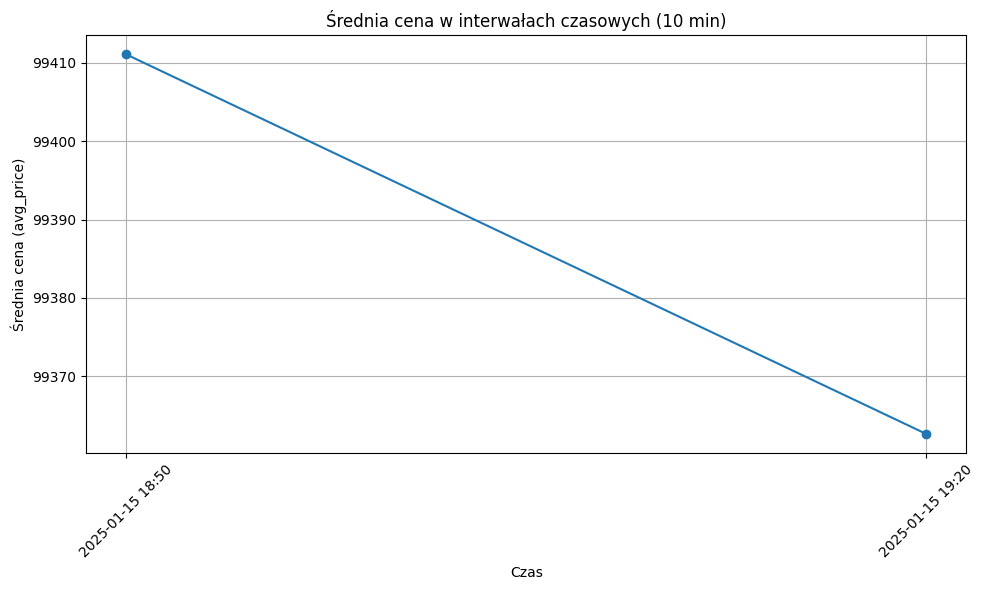

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

result_trades = client.sql.execute(query).result()

def convert_time_bucket_to_datetime(time_bucket):
    return datetime.utcfromtimestamp(time_bucket / 1000)

time_buckets = []
avg_prices = []

for row in result_trades:
    time_buckets.append(convert_time_bucket_to_datetime(row["time_bucket"]))
    avg_prices.append(row["avg_price"])

print(time_buckets)
# Tworzenie DataFrame
df = pd.DataFrame({"time_bucket": time_buckets, "avg_price": avg_prices})

plt.figure(figsize=(10, 6))
plt.plot(df["time_bucket"], df["avg_price"], marker='o')
plt.title("Średnia cena w interwałach czasowych (10 min)")
plt.xlabel("Czas")
plt.ylabel("Średnia cena (avg_price)")

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.xticks(time_buckets, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

###  Top 10 transakcji o najwyższej cenie

In [ ]:
query= """SELECT 
    JSON_VALUE(this, '$.time_unix' RETURNING BIGINT) AS transaction_time,
    CAST(JSON_VALUE(this, '$.price' RETURNING VARCHAR) AS DECIMAL) AS price,
    CAST(JSON_VALUE(this, '$.volume_24h' RETURNING VARCHAR) AS DECIMAL) AS volume
FROM coinbase_trades
WHERE JSON_VALUE(this, '$.product_id' RETURNING VARCHAR) = 'BTC-USD'
ORDER BY price DESC
LIMIT 10;
"""
result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "transaction_time": row["transaction_time"],  
        "price": row["price"],
        "volume": row["volume"]
    }
    trade["transaction_time"] = datetime.utcfromtimestamp(trade["transaction_time"] / 1000).strftime('%Y-%m-%d %H:%M')
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

   transaction_time     price          volume
0  2025-01-15 18:58  99450.04  12276.07988399
1  2025-01-15 18:58     99450  12275.22832153
2  2025-01-15 18:58     99450  12276.07963563
3  2025-01-15 18:58  99447.04  12276.24999127
4  2025-01-15 18:58  99447.03  12276.09560396
5  2025-01-15 18:58  99447.03  12276.11454193
6  2025-01-15 18:58  99447.03  12276.08086089
7  2025-01-15 18:58     99444  12275.21832153
8  2025-01-15 18:58  99443.32  12275.20332153
9  2025-01-15 18:58  99442.35  12275.20330853


### Średnia cena transakcji w stosunku do godziny dnia

   hour_of_day                                          avg_price
0           18  99411.0842800788954635108481262327416173570019...
1           19  99362.6500493653032440056417489421720733427362...


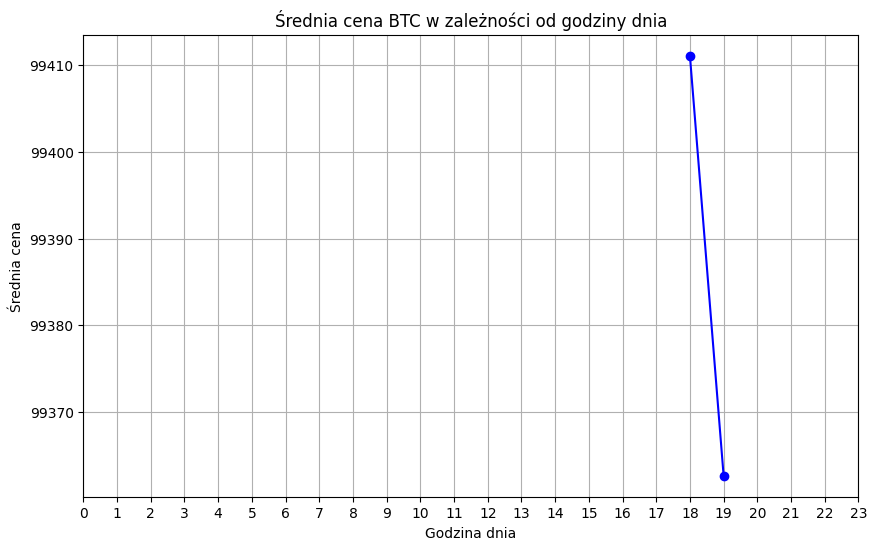

In [ ]:
import pandas as pd
from datetime import datetime

query = """SELECT 
    CAST((JSON_VALUE(this, '$.time_unix' RETURNING BIGINT) / 3600000) % 24 AS INT) AS hour_of_day,
    AVG(CAST(JSON_VALUE(this, '$.price' RETURNING VARCHAR) AS DECIMAL)) AS avg_price
FROM coinbase_trades
WHERE JSON_VALUE(this, '$.product_id' RETURNING VARCHAR) = 'BTC-USD'
GROUP BY hour_of_day
ORDER BY hour_of_day;
"""

result_trades = client.sql.execute(query).result()

result_trades_dict = []
for row in result_trades:
    trade = {
        "hour_of_day": row["hour_of_day"],
        "avg_price": row["avg_price"]
    }
    result_trades_dict.append(trade)

df = pd.DataFrame(result_trades_dict)
print(df)

plt.figure(figsize=(10, 6))
plt.plot(df['hour_of_day'], df['avg_price'], marker='o', linestyle='-', color='b')
plt.title('Średnia cena BTC w zależności od godziny dnia')
plt.xlabel('Godzina dnia')
plt.ylabel('Średnia cena')
plt.grid(True)
plt.xticks(range(24))  
plt.show()

### Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny

1736972891408


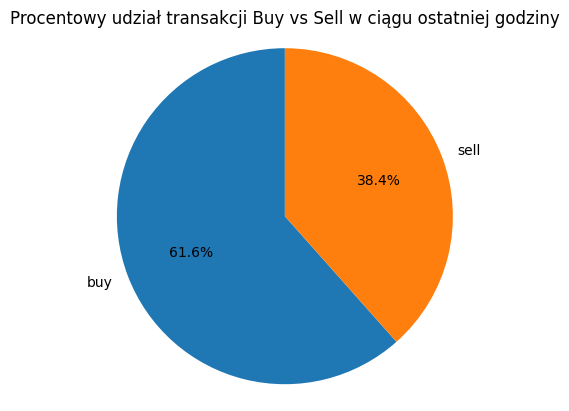

In [ ]:
from collections import Counter

from datetime import datetime

current_timestamp = int(datetime.utcnow().timestamp() * 1000)
print(current_timestamp)

query = f"""
SELECT 
    JSON_VALUE(this, '$.side' RETURNING VARCHAR) AS transaction_type,
    JSON_VALUE(this, '$.time_unix' RETURNING BIGINT) AS transaction_time
FROM coinbase_trades
WHERE JSON_VALUE(this, '$.product_id' RETURNING VARCHAR) = 'BTC-USD'
    AND JSON_VALUE(this, '$.time_unix' RETURNING BIGINT) > {current_timestamp - 3600000}  -- transakcje z ostatniej godziny
ORDER BY transaction_time;
"""

result_trades = client.sql.execute(query).result()

transaction_types = [trade["transaction_type"] for trade in result_trades]

counter = Counter(transaction_types)

labels = counter.keys()
sizes = counter.values()

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal') 

plt.title("Procentowy udział transakcji Buy vs Sell w ciągu ostatniej godziny")
plt.show()